In [2]:
from pyomo.environ import *
import numpy as np
import matplotlib.pyplot as plt
import bisect
from pyomo.opt import SolverStatus, TerminationCondition

In [3]:
def nc_underest(new_lb, new_ub, v_list, model_list, add_node_num=0, n_samples=5, tolerance=1e-8):
    """
    Parameters:
        delta (float): range of variable
        n_samples (float): number of sample nodes
        v_list (list): list of scenario functions  
        model: model with submodels corresponds to each scenario
        tolerance (float): decide when to stop

    Returns: delta (float): delta
             errors (float): hausdorff error
             y_nodes (list): y node (to make plot)
             as_nodes_list[0] (list): As node value (to make plot)
             ms_list[0] (float): ms for first scenario (to make plot)
    """
    N = len(model_list) 
    y_nodes = np.linspace(new_lb, new_ub, n_samples).tolist()
    lst = np.ones(N).tolist()
    y_opt_list = np.ones(N).tolist() 
    as_nodes_list = np.ones(N).tolist() 
    ms_list = np.ones(N).tolist() 
    
    current_new_nodes = []
    new_nodes_list = [None] * N
    
    #'''
    solver = SolverFactory('gurobi')
    solver.options['FeasibilityTol'] = 1e-9
    solver.options['OptimalityTol'] = tolerance
    solver.options['NonConvex'] = 2 
    #'''
    '''
    solver = SolverFactory('scip', executable='/Users/yinhuang/miniconda3/bin/scip')
    solver.options['numerics/feastol'] = tolerance
    solver.options['numerics/dualfeastol'] = tolerance
    solver.options['limits/gap'] = tolerance
    '''
        
    # reset bounds
    for i in range(N):
        model_list[i].y.setlb(new_lb)
        model_list[i].y.setub(new_ub)
    
    print('start')
    for k in range(add_node_num+1):
        print('Adding node ',k)
        for i in range(N):
            print('Solving scenario ',i)
            
            as_nodes_list[i] = [v_list[i](y) for y in y_nodes]
        
            # define piecewise function for each scenario
            if hasattr(model_list[i], 'As'):
                model_list[i].del_component('As')
            if hasattr(model_list[i], 'pw'):
                model_list[i].del_component('pw')
            if hasattr(model_list[i], 'obj'):
                model_list[i].del_component('obj')

            model_list[i].As = Var()
            model_list[i].pw = Piecewise(
                model_list[i].As, model_list[i].y,
                pw_pts=y_nodes,
                f_rule=as_nodes_list[i],
                pw_constr_type='EQ',
                pw_repn='SOS2'
            )

            model_list[i].obj = Objective(expr=model_list[i].obj_expr - model_list[i].As, sense=minimize)
            results = solver.solve(model_list[i])
            ms_list[i] = results.problem.lower_bound
            
            
            if (k == add_node_num) and (i == 0):
                last_ynode = value(model_list[i].y)
                print('')
                print('PPPPPPPPPPPPP')
                print('new node is ',last_ynode)
                
                


            
            # check if new node is too close to old nodes
            if (k > 0):
                print('哈哈哈哈哈')
                print('last node is ',new_nodes_list[i])
                print('new node is ',value(model_list[i].y))
                print(abs(new_nodes_list[i] - value(model_list[i].y)))
                print('')
                
            if (k > 0) and (abs(new_nodes_list[i] - value(model_list[i].y)) <= 1e-6):
                print("新点过近，未插入")
                break
            new_nodes_list[i] = value(model_list[i].y)
            if (new_nodes_list[i] not in y_nodes) and (k != add_node_num) and (i == 0):
                bisect.insort(y_nodes, new_nodes_list[i])
            #y_opt_list[i] = value(model_list[i].y)
          


    
    # define and solve the sum model
    #print(22)
    #assum_nodes = np.sum(as_nodes_list, axis=0).tolist()
    print('abab',len(y_nodes))
    print('aa',len(as_nodes_list[0]))
    assum_nodes = np.sum(as_nodes_list, axis=0)
    print('bb',len(as_nodes_list[0]))
    model_sum = ConcreteModel()
    model_sum.y = Var(bounds=(new_lb, new_ub))
    model_sum.As = Var()
    model_sum.pw = Piecewise(
        model_sum.As, model_sum.y,
        pw_pts=y_nodes,
        f_rule=list(assum_nodes),
        pw_constr_type='EQ',
        pw_repn='SOS2'
    )
    model_sum.obj = Objective(expr = model_sum.As, sense=minimize)
    solver.solve(model_sum)
    results = solver.solve(model_sum)
    if (results.solver.status == SolverStatus.ok) and (results.solver.termination_condition == TerminationCondition.optimal):
        pass
    else:
        print("bad bad bad")
    # get the output
    errors = results.problem.lower_bound + sum(ms_list)
    #errors = value(model_sum.obj) + sum(ms_list)
    errors = -errors
    
    #errors = -ms_list[0]
    delta = (new_ub-new_lb)/2
    
    print('node is ',add_node_num)
    print('error is ',errors)
    print('end')
    print(' ')
    print(' ')
    
    #return delta, errors, 1, 2  # diameter, error
    return delta, errors, y_nodes, as_nodes_list[0], ms_list[0], last_ynode,as_nodes_list[1], ms_list[1],

In [4]:
nc_underest(ylb,yub,v_list,[m1,m2],4)

NameError: name 'ylb' is not defined

In [5]:
# build function for each scenario 
def v_1(y):  
    if y < 5 or y > 20:
        return float('inf')
    elif 5 <= y < 6.53:
        return 2.5 * y - 10 * (2 * y - 10)
    else:
        return 2.5 * y - 10 * 20 / y


def v_2(y): 
    if y < 2.22 or y > 20:
        return float('inf')
    elif 2.22 <= y < 3.49:
        return 2.5 * y - 20 * (4.5 * y - 10)
    else:
        return 2.5 * y - 20 * 20 / y

v_list = [v_1, v_2]

# set up parameters and solvers
n_samples = 10
add_node_num=5
ylb = 6
yub = 15
tolerance=1e-9

m1 = ConcreteModel()
m1.y = Var(bounds=(ylb, yub))
m1.x1 = Var(bounds=(0, None))        ##################################
m1.c1 = Constraint(expr= 2*m1.y-m1.x1>=10)
m1.c2 = Constraint(expr= m1.x1 * m1.y<=20)
#m1.c3 = Constraint(expr= 2*sqrt(m1.x1+5)*log(m1.x1+2) <= 35)
m1.obj_expr = Expression(expr=2.5*m1.y - 10*m1.x1)

m2 = ConcreteModel()
m2.y = Var(bounds=(ylb, yub))
m2.x2 = Var(bounds=(0, None))        ##################################
m2.c1 = Constraint(expr= 4.5*m2.y-m2.x2>=10)
m2.c2 = Constraint(expr= m2.x2 * m2.y<=20)
#m1.c3 = Constraint(expr= 2*sqrt(m1.x1+5)*log(m1.x1+2) <= 35)
m2.obj_expr = Expression(expr=2.5*m2.y - 20*m2.x2)

In [6]:
# make delta list
##deltas = np.array([1, 1e-1, 1e-2,1e-03, 1e-4, 1e-5])
adds = np.arange(0, 4)
#adds = np.array([11,12,13,14,15,16])
#adds = np.array([15,16,17,18])
results = [nc_underest(ylb,yub,v_list,[m1,m2],a) for a in adds]

start
Adding node  0
Solving scenario  0
ERROR: Solver (gurobi) returned non-zero return code (1)
ERROR: Solver log: Traceback (most recent call last):
      File "<stdin>", line 5, in <module> File "D:\Anaconda\lib\site-
      packages\pyomo\solvers\plugins\solvers\GUROBI_RUN.py", line 62, in
      gurobi_run
        model = read(model_file)
                ^^^^^^^^^^^^^^^^
      File "src\\gurobipy\\gurobi.pxi", line 336, in gurobipy._core.read File
      "src\\gurobipy\\gurobi.pxi", line 116, in gurobipy._core.gurobi.read
      File "src\\gurobipy\\gurobi.pxi", line 60, in
      gurobipy._core.gurobi._getdefaultenv File "src\\gurobipy\\env.pxi", line
      108, in gurobipy._core.Env.__init__
    gurobipy._exception.GurobiError: No Gurobi license found (user pc, host
    DESKTOP-PPPCF27, hostid 3ef6820a, cores 10)


ApplicationError: Solver (gurobi) did not exit normally

   
   
   
add num  0
y node is  [ 6.    8.25 10.5  12.75 15.  ]
y node length 5
as_nodes is  [ -5.         -14.30234732 -14.2947553  -14.2947553   -3.61742424
  -3.61742424   7.20238095   7.20238095  16.18872549  24.16666667]
yas_nodes length 10
ms value is  -9.621132830790106
y_opt value is  6.531128874309123
   
   
   
add num  1
y node is  [ 6.          6.53112887  8.25       10.5        12.75       15.        ]
y node length 6
as_nodes is  [ -5.         -14.30234732 -14.2947553  -14.2947553   -3.61742424
  -3.61742424   7.20238095   7.20238095  16.18872549  24.16666667]
yas_nodes length 10
ms value is  -3.938252390867092e-09
y_opt value is  6.530072882389898
   
   
   
add num  2
y node is  [ 6.          6.53007288  6.53112887  8.25       10.5        12.75
 15.        ]
y node length 7
as_nodes is  [ -5.         -14.30234732 -14.2947553  -14.2947553   -3.61742424
  -3.61742424   7.20238095   7.20238095  16.18872549  24.16666667]
yas_nodes length 10
ms value is  -3.7530016012910

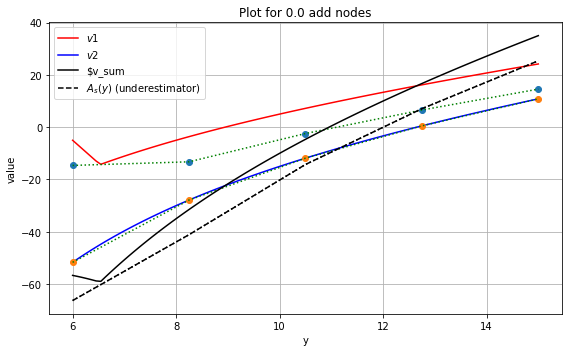

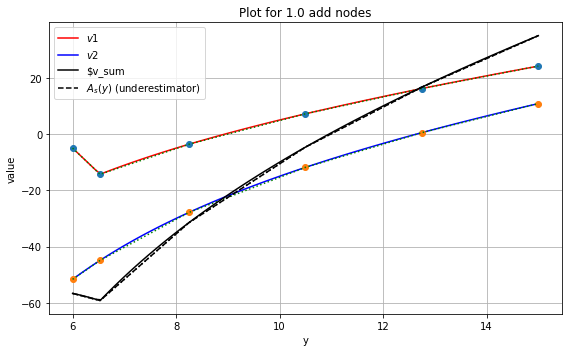

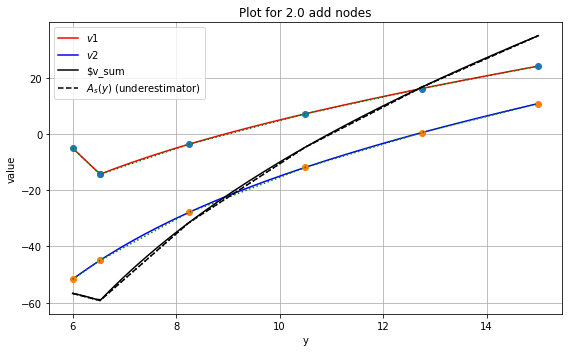

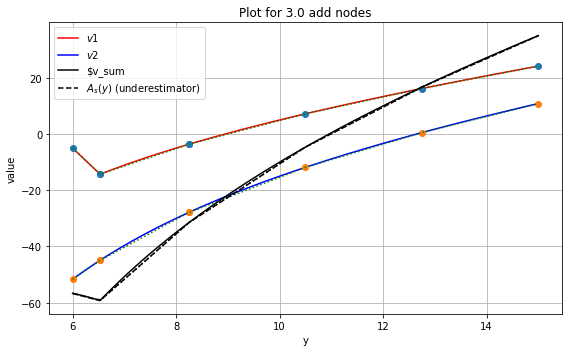

In [305]:
for i in range(len(results)):
    # y and z = |y|
    y_vals = np.linspace(ylb, yub, 100)
    Qs_vals1 = [v_list[0](y) for y in y_vals]
    Qs_vals2 = [v_list[1](y) for y in y_vals]
    Qs_vals_sum = np.array(Qs_vals1) + np.array(Qs_vals2)

    # As(y)
    y_nodes = np.array(results[i][2])
    as_nodes1 = np.array(results[i][3])
    as_nodes2 = np.array(results[i][-2])
    bbb1 = np.array(as_nodes1)
    bbb2 = np.array(as_nodes2)
    bbb_sum = bbb1+bbb2
    ms1 = results[i][4]
    ms2 = results[i][-1]
    #err = -results[i][1]
    err = ms1+ms2
    
    print("   ")
    print("   ")
    print("   ")
    print('add num ',i)
    print('y node is ',y_nodes)
    print('y node length',len(y_nodes))
    print('as_nodes is ',as_nodes)
    print('yas_nodes length',len(as_nodes))
    print("ms value is ",results[i][4])
    print("y_opt value is ",results[i][5])

    # make the plot
    plt.figure(figsize=(8, 5))
    plt.plot(y_vals, Qs_vals1, label=r'$v1$', color='red')
    #plt.plot(y_nodes, bbb1, label=r'$A_s(y)$ (underestimator)', color='blue', linestyle='--')
    plt.plot(y_nodes, bbb1+ms1, 'o')
    plt.plot(y_nodes, bbb1+ms1, color='green', linestyle=':')
    
    plt.plot(y_vals, Qs_vals2, label=r'$v2$', color='blue')
    #plt.plot(y_nodes, bbb2, label=r'$A_s(y)$ (underestimator)', color='blue', linestyle='--')
    plt.plot(y_nodes, bbb2+ms2, 'o')
    plt.plot(y_nodes, bbb2+ms2, color='green', linestyle=':')
    
    plt.plot(y_vals, Qs_vals_sum, label=r'$v_sum', color='black')
    #plt.plot(y_nodes, bbb_sum+err, 'o',color='black')
    plt.plot(y_nodes, bbb_sum+err, color='black', linestyle=':')
    plt.plot(y_nodes, bbb_sum+err, label=r'$A_s(y)$ (underestimator)', color='black', linestyle='--')
    
    plt.xlabel('y')
    plt.ylabel('value')
    #plt.title('Correct: $A_s(y) + m_s$ is a global underestimator of $Q_s(y)$')
    plt.title(f"Plot for {i:.1f} add nodes")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    
    



plt.show()

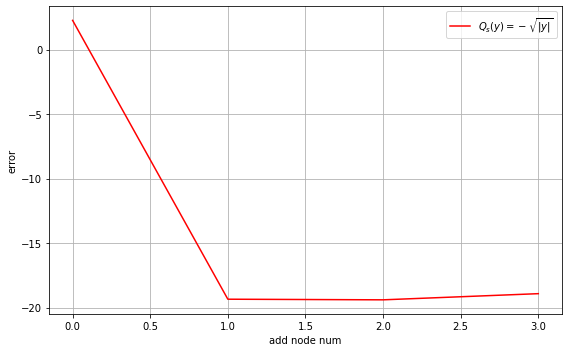

In [283]:
plt.figure(figsize=(8, 5))
errors = [item[1] for item in results]
plt.plot(adds, np.log(errors), label=r'$Q_s(y) = -\sqrt{|y|}$', color='red')

plt.xlabel('add node num')
plt.ylabel('error')
#plt.title(f"Plot for {0:.1f} add nodes")
plt.legend()
plt.grid(True)
#plt.xlim(-0.2, 0.2)  
#plt.ylim(-0.5, 0)  

plt.tight_layout()

In [ ]:
results = solverscip.solve(m1)
ccc = results.problem.lower_bound
ccc

In [ ]:
# y and z = |y|
y_vals = np.linspace(ylb, yub, 1001)
Qs_vals = [v_1(y) for y in y_vals]

#print("ms value is ",results[i][4])
#print("y_opt value is ",results[i][5])
#z_nodes = abs(y_nodes)
#as_nodes = np.sqrt(z_nodes)
aaa = y_nodes
bbb = as_nodes
bbb2 = np.array(bbb)
#As_vals2 = np.interp(z_vals, aaa, bbb2)
#As_shifted_vals2 = As_vals2 + ccc

# make the plot
plt.figure(figsize=(8, 5))
plt.plot(y_vals, Qs_vals, label=r'$Q_s(y) = -\sqrt{|y|}$', color='red')
#plt.plot(y_vals, As_vals2, label=r'$A_s(y)$ (underestimator)', color='blue', linestyle='--')
plt.plot(aaa, bbb2, label=r'$A_s(y)$ (underestimator)', color='blue', linestyle='--')
#plt.plot(y_vals, As_shifted_vals2, label=r'$A_s(y) + m_s$', color='green', linestyle=':')
plt.plot(aaa, bbb2+ccc, 'o')
plt.plot(aaa, bbb2+ccc, color='green', linestyle=':')
plt.xlabel('y')
plt.ylabel('value')
#plt.title('Correct: $A_s(y) + m_s$ is a global underestimator of $Q_s(y)$')
plt.title(f"Plot for {0:.1f} add nodes")
plt.legend()
plt.grid(True)
#plt.xlim(-0.2, 0.2)  
#plt.ylim(-0.5, 0)  

plt.tight_layout()